# ※ 과제 안내
- 과제 배점: 각 문제당 10점, 총점 100점입니다. 부분 점수는 제공되지 않습니다.  

- 채점 기준:  
    - 출력 결과 일치: 제출한 코드가 제시된 출력 결과와 일치하는 경우에만 정답으로 인정됩니다.  
    - 코드의 다양성 인정: 출력 결과가 동일하다면 다양한 접근 방식을 존중하여 정답으로 인정합니다.

---
# 12주차 과제

In [2]:
import warnings
warnings.filterwarnings('ignore')

---
# Q1. XOR Neural Network

In [3]:
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!pip install torch

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)


In [4]:
# === 1-1: 라이브러리 및 데이터 생성 ===

'''
목적: XOR 데이터를 Gaussian noise를 추가하여 생성합니다.

요구사항:

기본 XOR 데이터 ((0,0)->0, (1,1)->0, (1,0)->1, (0,1)->1)를 기반으로 합니다.

전체 데이터는 총 200개이며, Gaussian noise (평균=0, 표준편차=0.1)를 추가합니다.

Train/Test 데이터를 80:20 비율로 분할합니다.
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def create_xor_data(n_samples=200, noise_std=0.1, random_seed=42):
    """
    - 기본 XOR 데이터에 Gaussian noise 추가
    - train/test 80/20 분할
    """
    np.random.seed(random_seed)

    # 기본 XOR 패턴
    X_base = np.array([[0,0], [0,1], [1,0], [1,1]])
    y_base = np.array([0, 1, 1, 0])   # XOR 결과

    # 샘플 수 분배
    per_class = n_samples // 4
    rem = n_samples % 4

    X = np.repeat(X_base, per_class, axis=0)
    y = np.repeat(y_base, per_class, axis=0)

    if rem > 0:
        idx = np.random.choice(4, rem, replace=False)
        X = np.vstack([X, X_base[idx]])
        y = np.hstack([y, y_base[idx]])

    # Gaussian noise 추가
    X = X + np.random.randn(n_samples, 2) * noise_std

    # train/test split (80:20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed, stratify=y
    )

    return X_train, X_test, y_train, y_test


# 데이터 준비
X_train, X_test, y_train, y_test = create_xor_data()
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 160, Test samples: 40


In [5]:
# === 1-2: 모델 정의 ===
'''
목적: XOR 문제를 풀 신경망 모델을 클래스 형태로 정의합니다.

요구사항:

클래스명: XORNet

메서드 정의:

__init__: 모델의 구조 정의 및 가중치, 편향 초기화

forward: 입력 데이터를 받아 순전파 계산

backward: 역전파 계산하여 gradient 계산

update: 계산된 gradient를 이용하여 파라미터 업데이트
'''

class XORNet:
    def __init__(self, input_dim=2, hidden_dim=8, lr=0.1, reg=1e-4, momentum=0.9):
        """
        - W1: (input_dim × hidden_dim), b1: (1×hidden_dim)
        - W2: (hidden_dim × 1),       b2: (1×1)
        - Xavier 초기화 권장
        """
        # Xavier 초기화
        limit1 = np.sqrt(6 / (input_dim + hidden_dim))
        self.W1 = np.random.uniform(-limit1, limit1, (input_dim, hidden_dim))
        self.b1 = np.zeros((1, hidden_dim))

        limit2 = np.sqrt(6 / (hidden_dim + 1))
        self.W2 = np.random.uniform(-limit2, limit2, (hidden_dim, 1))
        self.b2 = np.zeros((1, 1))

        self.lr = lr
        self.reg = reg
        self.momentum = momentum

        # Momentum 변수 초기화
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)

    def forward(self, X):
        """
        - Z1 = X·W1 + b1
        - A1 = ReLU(Z1)
        - Z2 = A1·W2 + b2
        - A2 = sigmoid(Z2)
        """
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = np.maximum(0, self.Z1)  # ReLU
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = 1 / (1 + np.exp(-self.Z2))  # sigmoid
        return self.A2

    def backward(self, X, y):
        """
        - CrossEntropy + L2 regularization
        - dW2, db2, dW1, db1 계산 (벡터화 필수)
        """
        m = X.shape[0]
        y = y.reshape(-1, 1)

        # Loss gradient wrt output (sigmoid + BCE)
        dZ2 = self.A2 - y
        self.dW2 = (self.A1.T @ dZ2) / m + self.reg * self.W2
        self.db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (self.Z1 > 0)  # ReLU 미분
        self.dW1 = (X.T @ dZ1) / m + self.reg * self.W1
        self.db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    def update(self):
        """
        - Momentum(0.9) 포함 SGD 업데이트
        """
        # Momentum SGD update
        self.vW1 = self.momentum * self.vW1 - self.lr * self.dW1
        self.vb1 = self.momentum * self.vb1 - self.lr * self.db1
        self.vW2 = self.momentum * self.vW2 - self.lr * self.dW2
        self.vb2 = self.momentum * self.vb2 - self.lr * self.db2

        self.W1 += self.vW1
        self.b1 += self.vb1
        self.W2 += self.vW2
        self.b2 += self.vb2


In [6]:
# === 1-3: 학습 루프 ===
'''
1-3 학습 과정 코드 구현
목적: 정의된 XORNet 클래스를 활용하여 데이터를 학습합니다.

요구사항:

Epoch 마다 데이터 셔플링

미니배치로 나눠 학습을 진행합니다.
'''
def train_model(model, X_train, y_train, X_test, y_test,
                epochs=5000, batch_size=32, early_stop=50):
    """
    - 미니배치 SGD
    - 매 100 iters마다 train loss 저장
    - early stopping: 검증 정확도(또는 loss) 개선 없으면 중단
    """
    history = {'loss': [], 'val_acc': []}
    best_acc, wait = 0, 0
    n = X_train.shape[0]
    iter_count = 0

    for ep in range(1, epochs+1):
        '''코드 작성'''
        # Shuffle
        idx = np.random.permutation(n)
        X_sh = X_train[idx]
        y_sh = y_train[idx]

        for i in range(0, n, batch_size):
            xb = X_sh[i:i+batch_size]
            yb = y_sh[i:i+batch_size]
            # forward & backward & update
            _ = model.forward(xb)
            model.backward(xb, yb)
            model.update()
            iter_count += 1

            # 기록: 100 iters마다
            if iter_count % 100 == 0:
                # train loss
                preds = model.forward(X_train)
                loss = -np.mean(y_train*np.log(preds+1e-8)+(1-y_train)*np.log(1-preds+1e-8))
                history['loss'].append(loss)
                # val accuracy
                val_preds = model.forward(X_test) >= 0.5
                acc = np.mean(val_preds.flatten() == y_test)
                history['val_acc'].append(acc)
                # early stopping
                if acc > best_acc:
                    best_acc = acc
                    wait = 0
                else:
                    wait += 1
                if wait >= early_stop:
                    print(f"Early stopping at epoch {ep}, iter {iter_count}")
                    return history

    return history

# 학습 실행
model = XORNet()
history = train_model(model, X_train, y_train, X_test, y_test)

Early stopping at epoch 1020, iter 5100


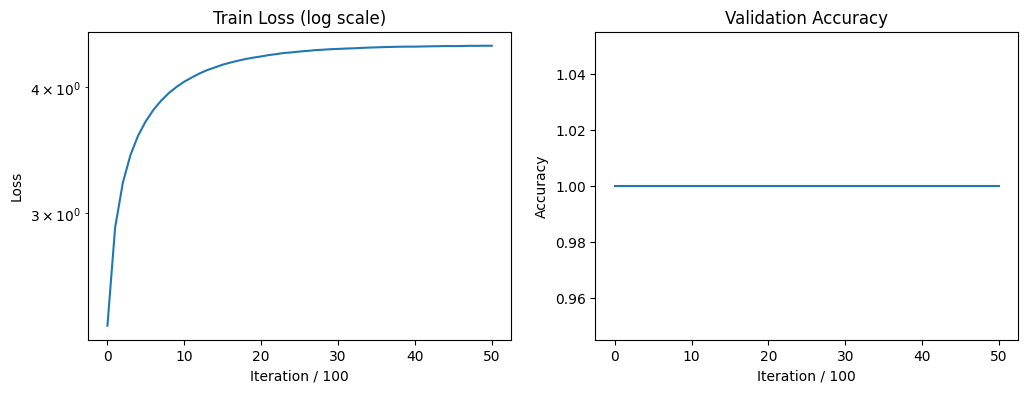

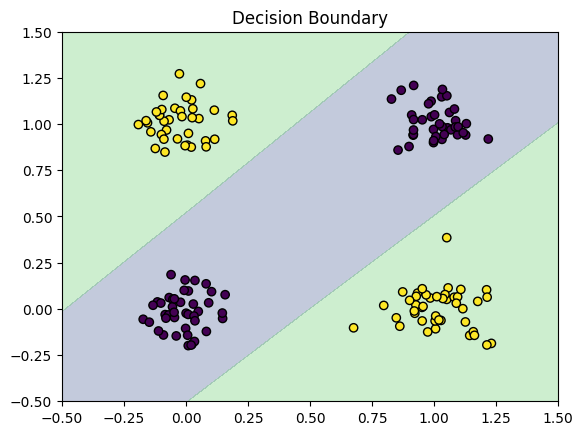

In [7]:
# === 1-4: 시각화 및 평가 ===
'''
목적: 학습된 XORNet의 Loss 및 Accuracy를 시각화하고 Decision Boundary를 그래픽으로 표현합니다.

요구사항:

Loss와 Accuracy의 epoch에 따른 변화를 그래프로 시각화합니다.

Decision Boundary를 0.5를 기준으로 Grid 데이터를 통해 시각화합니다.
'''

# 1) 학습 곡선
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
'''코드 작성'''
plt.plot(history['loss'])
plt.yscale('log')
plt.title("Train Loss (log scale)")
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")

plt.subplot(1,2,2)
'''코드 작성'''
plt.plot(history['val_acc'])
plt.title("Validation Accuracy")
plt.xlabel("Iteration / 100")
plt.ylabel("Accuracy")
plt.show()

# 2) 결정 경계 시각화
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200),
                     np.linspace(-0.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

'''코드 작성'''
Z = model.forward(grid)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1,0.5,1.1])
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolor='k')
plt.title("Decision Boundary")
plt.show()


---
# Q2. Logistic Regression

In [8]:
# 2-1: 라이브러리 및 데이터 전처리
'''
목적:

Iris 데이터를 이진 분류 문제로 변형하고, 학습을 위한 전처리 작업을 수행합니다.

상세 요구사항:

Iris 데이터셋에서 클래스 0과 클래스 1 데이터만 추출하여 사용합니다.

데이터 표준화(Standardization)를 수행합니다.

다항식 특성 확장(Polynomial feature expansion)을 수행합니다. (degree=2)

데이터셋을 train/validation으로 70:30 비율로 분할합니다.
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from itertools import combinations_with_replacement

def load_preprocess_data(degree=2):
    """
    - Iris 데이터(이진 분류: 클래스 0 vs 1)
    - 표준화 및 다항식 특성 확장 (degree까지)
    - train/val 70/30 분할 반환
    """
    '''코드 작성'''
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target

    # 클래스 0과 1만 선택
    mask = (y == 0) | (y == 1)
    X = X[mask]
    y = y[mask]

    # Standardize
    mu, sigma = X.mean(axis=0), X.std(axis=0)
    Xs = (X - mu) / sigma

    # Polynomial feature expansion
    n, d = Xs.shape
    features = [np.ones(n)]
    for deg in range(1, degree+1):
        for comb in combinations_with_replacement(range(d), deg):
            feat = np.prod(Xs[:, comb], axis=1)
            features.append(feat)
    X_poly = np.vstack(features).T

    return train_test_split(X_poly, y, test_size=0.3, random_state=0)

In [9]:
# 2-2: 모델 클래스 정의
'''
목적:

Logistic Regression 모델을 클래스 형태로 구현하여 모델을 명확하게 구조화합니다.

상세 요구사항:

클래스명: LogisticRegression

클래스 내 구현할 메서드:

__init__: 모델의 파라미터(가중치, 편향)를 초기화합니다.

forward: 입력 데이터를 받아 순전파 계산 (sigmoid를 이용한 확률값 계산)을 수행합니다.

backward: 손실 함수의 기울기(gradient)를 역전파로 계산합니다.

update: 계산된 gradient를 이용하여 파라미터를 업데이트합니다.
'''
class LogisticRegressionNewton:
    def __init__(self, reg_lambda=1.0, line_search=True):
        """
        - reg_lambda: L2 정규화 강도
        - line_search: True이면 backtracking line search 적용
        """
        '''코드 작성'''
        self.reg = reg_lambda
        self.line_search = line_search
        self.w = None
        self.loss_history = []

    def fit(self, X, y, num_iter=50, tol=1e-6):
        """
        - 뉴턴법 최적화 구현
        - 매 이터레이션마다 loss 기록 (self.loss_history)
        - tol 기준으로 조기 종료
        """
        n, d = X.shape
        self.w = np.zeros(d)
        for it in range(num_iter):
            # Linear response & prob
            '''코드 작성'''
            z = X.dot(self.w)
            p = 1 / (1 + np.exp(-z))

            # Loss (Cross-Entropy + L2)
            '''코드 작성'''
            loss = -np.mean(y*np.log(p+1e-8) + (1-y)*np.log(1-p+1e-8))
            loss += 0.5 * self.reg * np.dot(self.w[1:], self.w[1:])
            self.loss_history.append(loss)

            # Gradient & Hessian
            grad = X.T.dot(p - y) / n
            grad[1:] += self.reg * self.w[1:]
            W = np.diag(p*(1-p))
            H = (X.T.dot(W).dot(X)) / n
            H[1:,1:] += self.reg * np.eye(d-1)

            # Newton step
            delta = np.linalg.solve(H, grad)

            # Backtracking line search
            lr = 1.0
            if self.line_search:
                for _ in range(10):
                    w_new = self.w - lr * delta
                    z_new = X.dot(w_new)
                    p_new = 1 / (1 + np.exp(-z_new))
                    loss_new = -np.mean(y*np.log(p_new+1e-8)+(1-y)*np.log(1-p_new+1e-8))
                    loss_new += 0.5 * self.reg * np.dot(w_new[1:], w_new[1:])
                    if loss_new < loss: break
                    lr *= 0.5

            # Update weights
            self.w -= lr * delta

            # Convergence check
            if np.linalg.norm(grad) < tol:
                print(f"Converged at iteration {it}")
                break

    def predict_proba(self, X):
        '''코드 작성'''
        z = X.dot(self.w)
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        '''코드 작성 threshold 0.5'''
        return (self.predict_proba(X) >= 0.5).astype(int)


In [10]:
# 2-3: 모델 학습
'''
목적:

정의된 Logistic Regression 모델을 실제 데이터에 학습시킵니다.

상세 요구사항:

Train Acc, Val Acc를 출력합니다.
'''
'''아래 출력문이 나오도록 코드 작성'''
X_train, X_val, y_train, y_val = load_preprocess_data()

model = LogisticRegressionNewton(reg_lambda=1.0, line_search=True)
model.fit(X_train, y_train)

print("Train Acc:", np.mean(model.predict(X_train) == y_train))
print("Val Acc:  ", np.mean(model.predict(X_val) == y_val))


Converged at iteration 3
Train Acc: 1.0
Val Acc:   1.0


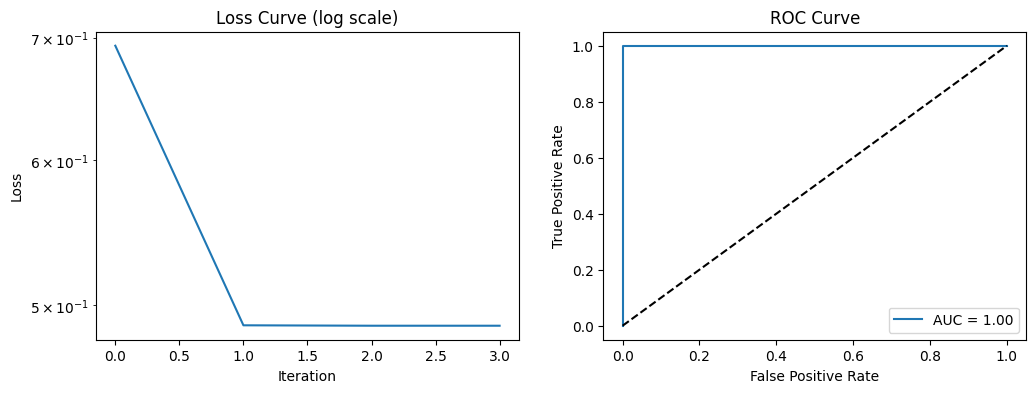

In [11]:
# 2-4: 시각화 및 평가
'''
목적:

모델의 학습 과정 중 손실(Loss)의 변화와 성능 평가를 위한 ROC Curve를 시각화합니다.

상세 요구사항:

Loss Curve를 iteration에 따라 시각화합니다. (Log scale)

ROC Curve를 시각화하고, ROC Curve의 면적을 나타내는 AUC(Area Under Curve) 값을 계산하여 그래프에 표시합니다.
'''
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12,4))

# 1) Loss Curve
plt.subplot(1,2,1)
plt.plot(model.loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve (log scale)")

# 2) ROC Curve
y_score = model.predict_proba(X_val)
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.show()


---
# Q3. Deep Autoencoder from Scratch (NumPy + Momentum)

In [12]:
!python.exe -m pip install --upgrade pip
!pip install tensorflow


In [13]:
# === 3-1: 라이브러리 및 데이터 로드 ===
'''
목적:

MNIST 데이터를 로드하고 전처리하여, Autoencoder 학습을 위한 입력 데이터를 준비합니다.

상세 요구사항:

MNIST 데이터셋을 로드합니다. (keras 라이브러리 사용)

전체 MNIST 데이터(train, test)를 합쳐서 사용합니다.

모든 픽셀 값을 [0, 255]에서 [0, 1]로 정규화(normalize)합니다.

데이터는 flatten (784차원) 하여 사용합니다. (28x28 이미지를 784차원의 벡터로)

최종적으로 훈련 데이터로 20,000개의 샘플만 추출하여 사용합니다.
'''
import numpy as np
import matplotlib.pyplot as plt

# MNIST 로드 (keras 사용)
from tensorflow.keras.datasets import mnist

(X_train_full, _), (X_test_full, _) = mnist.load_data()
X_full = np.concatenate([X_train_full, X_test_full], axis=0).astype(np.float32) / 255.0
X_full = X_full.reshape(-1, 784)

# 훈련 전용으로 20000개만 사용
idx = np.random.choice(X_full.shape[0], 20000, replace=False)
X_train = X_full[idx]

print(f"Training samples: {X_train.shape[0]}, dimension: {X_train.shape[1]}")


Training samples: 20000, dimension: 784


In [14]:
# === 3-2: NumpyAutoencoder 클래스 정의 ===
'''
목적:
Autoencoder를 NumPy로 직접 구현하여, 비지도 학습의 원리와 인코딩 및 디코딩의 구조적 이해를 돕습니다.

요구사항:
클래스명: NumpyAutoencoder

구현 메서드:
__init__
인코더/디코더 파라미터를 He 초기화, Momentum 초기화

forward
인코더 및 디코더를 통한 순전파 계산 (활성화 함수: ReLU, 출력층 선형)

compute_loss
복원 오차를 MSE로 계산

backward
역전파를 통한 Gradient 계산 및 Momentum 기반 파라미터 업데이트

fit
미니배치 단위 epoch별 학습 수행 및 loss 기록

reconstruct
입력 데이터의 복원 결과 반환

추가 세부사항:
인코더/디코더 구조는 대칭적으로 구성

활성화 함수는 중간층에만 ReLU 적용
'''
class NumpyAutoencoder:
    def __init__(self, input_dim, hidden_dims, lr=1e-3, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        # Encoder parameters
        self.W_enc = []
        self.b_enc = []
        in_dim = input_dim
        for h in hidden_dims:
            W = np.random.randn(in_dim, h) * np.sqrt(2.0 / in_dim)
            b = np.zeros((1, h))
            self.W_enc.append(W)
            self.b_enc.append(b)
            in_dim = h

        # Decoder parameters (mirror)
        hidden_dims_rev = hidden_dims[::-1] + [input_dim]
        self.W_dec = []
        self.b_dec = []
        in_dim = hidden_dims[-1]
        for h in hidden_dims_rev:
            W = np.random.randn(in_dim, h) * np.sqrt(2.0 / in_dim)
            b = np.zeros((1, h))
            self.W_dec.append(W)
            self.b_dec.append(b)
            in_dim = h

        # Velocity for momentum
        self.vW_enc = [np.zeros_like(W) for W in self.W_enc]
        self.vb_enc = [np.zeros_like(b) for b in self.b_enc]
        self.vW_dec = [np.zeros_like(W) for W in self.W_dec]
        self.vb_dec = [np.zeros_like(b) for b in self.b_dec]

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        self.cache = {}
        a = X
        # Encoder
        for i, (W, b) in enumerate(zip(self.W_enc, self.b_enc)):
            z = a.dot(W) + b
            a = self.relu(z)
            self.cache[f'z_enc{i}'] = z
            self.cache[f'a_enc{i}'] = a

        # Decoder
        for i, (W, b) in enumerate(zip(self.W_dec, self.b_dec)):
            z = a.dot(W) + b
            if i == len(self.W_dec) - 1:
                a = z
            else:
                a = self.relu(z)
            self.cache[f'z_dec{i}'], self.cache[f'a_dec{i}'] = z, a
        return a

    def compute_loss(self, X, X_recon):
        return np.mean((X_recon - X) ** 2)

    def backward(self, X):
        m = X.shape[0]
        # Reconstruction gradient
        a_dec = self.cache[f'a_dec{len(self.W_dec)-1}']
        da = 2*(a_dec - X) / m
        # Decoder backward
        for i in reversed(range(len(self.W_dec))):
            z = self.cache[f'z_dec{i}']
            if i == len(self.W_dec) - 1:
                dz = da
            else:
                dz = da * self.relu_derivative(z)
            a_prev = self.cache[f'a_enc{len(self.W_enc)-1}'] if i==0 else self.cache[f'a_dec{i-1}']
            dW = a_prev.T.dot(dz)
            db = np.sum(dz, axis=0, keepdims=True)
            da = dz.dot(self.W_dec[i].T)
            # Momentum update
            self.vW_dec[i] = self.momentum*self.vW_dec[i] - self.lr*dW
            self.W_dec[i] += self.vW_dec[i]
            self.vb_dec[i] = self.momentum*self.vb_dec[i] - self.lr*db
            self.b_dec[i] += self.vb_dec[i]
        # Encoder backward
        for i in reversed(range(len(self.W_enc))):
            z = self.cache[f'z_enc{i}']
            dz = da * self.relu_derivative(z)
            if i == 0:
                a_prev = X
            else:
                a_prev = self.cache[f'a_enc{i-1}']
            dW = a_prev.T.dot(dz)
            db = np.sum(dz, axis=0, keepdims=True)
            da = dz.dot(self.W_enc[i].T)
            self.vW_enc[i] = self.momentum*self.vW_enc[i] - self.lr*dW
            self.W_enc[i] += self.vW_enc[i]
            self.vb_enc[i] = self.momentum*self.vb_enc[i] - self.lr*db
            self.b_enc[i] += self.vb_enc[i]

    def fit(self, X, epochs=20, batch_size=128):
        n = X.shape[0]
        history = {'loss': []}
        for ep in range(1, epochs+1):
            perm = np.random.permutation(n)
            for i in range(0, n, batch_size):
                batch_idx = perm[i:i+batch_size]
                X_batch = X[batch_idx]
                X_recon = self.forward(X_batch)
                self.backward(X_batch)
            # epoch loss
            full_recon = self.forward(X)
            loss = self.compute_loss(X, full_recon)
            history['loss'].append(loss)
            print(f"Epoch {ep}/{epochs} - Loss: {loss:.6f}")
        return history

    def reconstruct(self, X):
        return self.forward(X)

In [15]:
# === 3-3: 모델 학습 ===
model = NumpyAutoencoder(input_dim=784, hidden_dims=[256,64], lr=1e-3, momentum=0.9)
history = model.fit(X_train, epochs=20, batch_size=256)

Epoch 1/20 - Loss: 0.067143
Epoch 2/20 - Loss: 0.067126
Epoch 3/20 - Loss: 0.067122
Epoch 4/20 - Loss: 0.067121
Epoch 5/20 - Loss: 0.067117
Epoch 6/20 - Loss: 0.067100
Epoch 7/20 - Loss: 0.067123
Epoch 8/20 - Loss: 0.067122
Epoch 9/20 - Loss: 0.067123
Epoch 10/20 - Loss: 0.067124
Epoch 11/20 - Loss: 0.067126
Epoch 12/20 - Loss: 0.067123
Epoch 13/20 - Loss: 0.067126
Epoch 14/20 - Loss: 0.067123
Epoch 15/20 - Loss: 0.067123
Epoch 16/20 - Loss: 0.067123
Epoch 17/20 - Loss: 0.067124
Epoch 18/20 - Loss: 0.067123
Epoch 19/20 - Loss: 0.067123
Epoch 20/20 - Loss: 0.067123


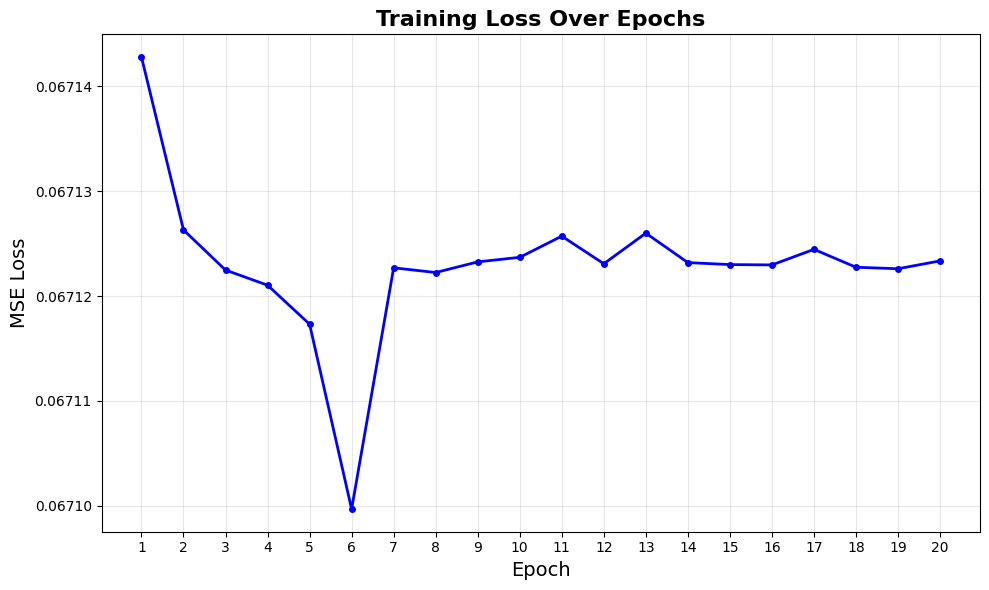

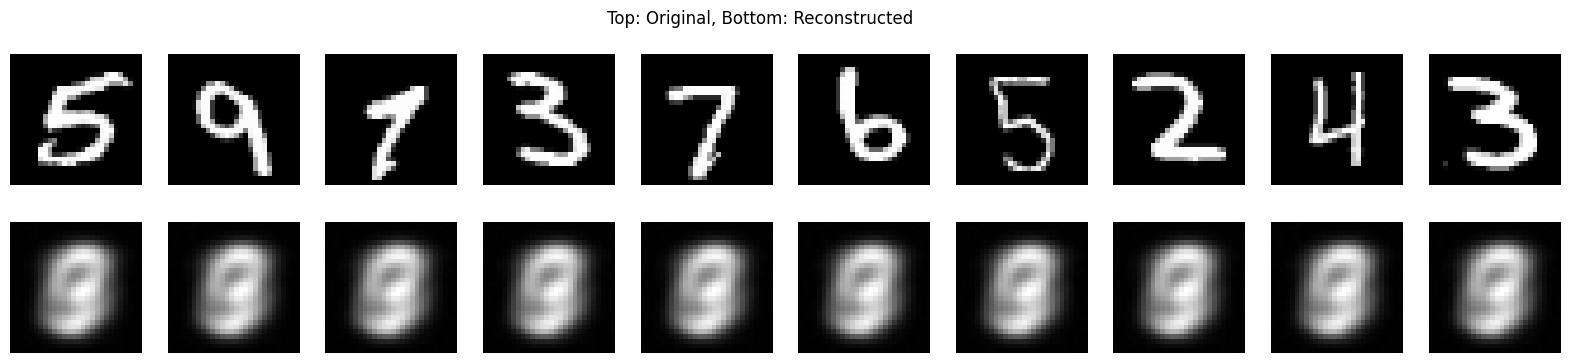

In [16]:
# === 3-4: 시각화 및 재구성 결과 ===
'''
목적:
학습된 Autoencoder의 복원 성능과 학습 과정(손실)을 시각적으로 확인하여 평가합니다.

요구사항:
손실 곡선 시각화 - Epoch에 따른 MSE Loss 변화 그래프

재구성 결과 시각화 - 원본 MNIST 이미지와 Autoencoder가 재구성한 이미지를 나란히 비교 시각화 (샘플 10개)

추가 세부사항:
손실곡선의 y축은 MSE Loss로 명확히 표기

시각화된 이미지: 상단은 원본 이미지, 하단은 복원된 이미지로 표현
'''
# 손실 곡선
'''손실 곡선 그래프 나오도록 코드 작성'''
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], 'b-', linewidth=2, marker='o', markersize=4)
plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(history['loss'])+1))
plt.tight_layout()
plt.show()


# 몇 개 샘플 재구성 시각화
n_show = 10
X_vis = X_full[20000:20000+n_show]
recon_vis = model.reconstruct(X_vis)

fig, axes = plt.subplots(2, n_show, figsize=(20,4))
for i in range(n_show):
    axes[0,i].imshow(X_vis[i].reshape(28,28), cmap='gray'); axes[0,i].axis('off')
    axes[1,i].imshow(recon_vis[i].reshape(28,28), cmap='gray'); axes[1,i].axis('off')
fig.suptitle("Top: Original, Bottom: Reconstructed")
plt.show()

---
# Q4. Deep MLP from Scratch (NumPy + BatchNorm + Dropout)

In [17]:
# === 4-1: 라이브러리 및 데이터 준비 ===
'''
목적:
Digits 데이터셋을 활용하여 0~4 숫자 이미지를 분류하는 다중 클래스 분류(Multi-class classification)를 위한 데이터를 준비하고, 필요한 유틸리티 함수를 정의합니다.

요구사항:
Digits 데이터셋에서 클래스 0~4만 추출, 픽셀 값을 [0,1]로 정규화

One-hot Encoding을 수행하여 다중 클래스 분류 준비

Train/Validation 데이터를 80:20으로 분할

Xavier 초기화 함수 (xavier_init) 및 활성화 함수 (ELU)와 미분 함수 (elu_grad)를 유틸리티 함수로 정의하여 준비합니다.
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1) Digits 0-4 필터링, [0,1] 정규화
digits = load_digits()
mask = digits.target < 5
X = digits.data[mask] / 16.0
y = digits.target[mask].reshape(-1,1)

# 2) One-hot 인코딩
onehot = OneHotEncoder(sparse_output=False)
y_encoded = onehot.fit_transform(y)


# 3) Train/Val 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


# 4) 유틸 함수
def xavier_init(fan_in, fan_out):
    return np.random.randn(fan_in, fan_out) * np.sqrt(2.0/(fan_in+fan_out))

def elu(x, alpha=1.0):
    return np.where(x>0, x, alpha*(np.exp(x)-1))

def elu_grad(x, alpha=1.0):
    return np.where(x>0, 1, alpha*np.exp(x))


In [18]:
# === 4-2: NumpyMLPAdvanced 클래스 ===
'''
목적:
NumPy를 사용하여 고급 기능을 포함한 다층 퍼셉트론(MLP)을 구현하고, 딥러닝 모델 학습 원리를 학습합니다.

요구사항:
클래스명: NumpyMLPAdvanced

아래 기능을 포함하여 클래스 정의:

파라미터 초기화 (Xavier 초기화)

순전파(forward propagation): ELU 활성화, Batch Normalization, Dropout, 출력층 Softmax

역전파(backward propagation): 역전파를 통한 기울기 계산, Gradient clipping, Batch Normalization 역전파 구현

최적화 방법: Momentum 기반 SGD 및 Adam 최적화 알고리즘 구현

학습 과정(fit): 미니배치 학습, Cosine Annealing 학습률 스케줄링, epoch마다 학습 및 검증 성능 기록

세부 구현 사항:
활성화 함수: ELU 사용

출력층 활성화: Softmax 함수 사용

손실 함수: 교차 엔트로피(Cross Entropy Loss) + L2 정규화

Epoch마다 train/val 손실(loss), 정확도(acc), 기울기 norm, 파라미터 norm 기록

최종 예측 메서드(predict) 정의
'''
class NumpyMLPAdvanced:
    def __init__(self, layer_sizes, lr=1e-3, reg=1e-4, momentum=0.9,
                 beta1=0.9, beta2=0.999, eps=1e-8, dropout_rate=0.5):
        self.L = len(layer_sizes)-1
        self.layer_sizes = layer_sizes
        self.lr0, self.reg, self.mom = lr, reg, momentum
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.dr = dropout_rate

        # 파라미터 초기화
        self.W = {i: xavier_init(layer_sizes[i], layer_sizes[i+1]) for i in range(self.L)}
        self.b = {i: np.zeros((1, layer_sizes[i+1])) for i in range(self.L)}

        # BatchNorm 파라미터
        self.gamma = {i: np.ones((1,layer_sizes[i+1])) for i in range(self.L-1)}
        self.beta  = {i: np.zeros((1,layer_sizes[i+1])) for i in range(self.L-1)}
        self.running_mean = {i: np.zeros((1,layer_sizes[i+1])) for i in range(self.L-1)}
        self.running_var  = {i: np.ones((1,layer_sizes[i+1]))  for i in range(self.L-1)}

        # Optimizer state
        self.vW  = {i: np.zeros_like(self.W[i]) for i in range(self.L)}
        self.vb  = {i: np.zeros_like(self.b[i]) for i in range(self.L)}
        self.mW  = {i: np.zeros_like(self.W[i]) for i in range(self.L)}
        self.vW_adam = {i: np.zeros_like(self.W[i]) for i in range(self.L)}
        self.mb  = {i: np.zeros_like(self.b[i]) for i in range(self.L)}
        self.vb_adam = {i: np.zeros_like(self.b[i]) for i in range(self.L)}

    def forward(self, X, is_training=True):
        self.cache = {}
        out = X.copy()
        for i in range(self.L):
            Z = out.dot(self.W[i]) + self.b[i]
            self.cache[f'Z{i}'] = Z
            if i < self.L-1:
                # BatchNorm
                if is_training:
                    mu  = Z.mean(axis=0, keepdims=True)
                    var = Z.var(axis=0, keepdims=True) + 1e-5
                    self.running_mean[i] = 0.9*self.running_mean[i] + 0.1*mu
                    self.running_var[i]  = 0.9*self.running_var[i]  + 0.1*var
                    Zn  = (Z - mu) / np.sqrt(var)
                else:
                    mu  = self.running_mean[i]
                    var = self.running_var[i]
                    Zn  = (Z - mu) / np.sqrt(var)
                Zb = self.gamma[i]*Zn + self.beta[i]
                # cache all three for backward
                self.cache[f'Zn{i}'], self.cache[f'mu{i}'], self.cache[f'var{i}'] = Zn, mu, var

                # ELU activation
                A = elu(Zb)
                self.cache[f'A{i}'] = A

                # Dropout
                if is_training:
                    mask = (np.random.rand(*A.shape) > self.dr) / (1 - self.dr)
                    A *= mask
                    self.cache[f'mask{i}'] = mask

                out = A
            else:
                # final Softmax
                expZ = np.exp(Z - Z.max(axis=1, keepdims=True))
                out = expZ / expZ.sum(axis=1, keepdims=True)
                self.cache[f'A{i}'] = out

        return out


    def compute_loss_and_grads(self, X, Y):
        m = X.shape[0]
        Y_pred = self.forward(X, is_training=True)
        # Loss
        loss = -np.sum(Y * np.log(Y_pred + 1e-8)) / m
        for i in range(self.L):
            loss += 0.5 * self.reg * np.sum(self.W[i]**2)
        # Backward
        grads = {}
        dA = (Y_pred - Y) / m
        for i in reversed(range(self.L)):
            A_prev = X if i==0 else self.cache[f'A{i-1}']
            grads[f'dW{i}'] = A_prev.T.dot(dA) + self.reg * self.W[i]
            grads[f'db{i}'] = np.sum(dA, axis=0, keepdims=True)
            if i>0:
                dZ = dA.dot(self.W[i].T)
                dZ *= self.cache[f'mask{i-1}']
                Zb = self.cache[f'Zn{i-1}']*np.sqrt(self.cache[f'var{i-1}']) + self.cache[f'mu{i-1}']
                dZ = dZ * elu_grad(Zb)
                Zn, mu, var = (self.cache[f'Zn{i-1}'],
                               self.cache[f'mu{i-1}'],
                               self.cache[f'var{i-1}'])
                dgamma = np.sum(dZ * Zn, axis=0, keepdims=True)
                dbeta  = np.sum(dZ,      axis=0, keepdims=True)
                grads[f'dgamma{i-1}'], grads[f'dbeta{i-1}'] = dgamma, dbeta
                dZn = dZ * self.gamma[i-1]
                dvar = np.sum(dZn*(self.cache[f'Z{i-1}']-mu)*-0.5*(var**-1.5), axis=0, keepdims=True)
                dmu  = (np.sum(dZn*-1/np.sqrt(var),axis=0,keepdims=True)
                        + dvar*np.mean(-2*(self.cache[f'Z{i-1}']-mu),axis=0,keepdims=True))
                dA = dZn/np.sqrt(var) + dvar*2*(self.cache[f'Z{i-1}']-mu)/m + dmu/m
        # Gradient clipping
        total_norm = np.sqrt(sum(np.sum(grads[f'dW{i}']**2) for i in range(self.L)))
        clip_coef = 5.0/(total_norm+1e-6) if total_norm>5.0 else 1.0
        for i in range(self.L):
            grads[f'dW{i}'] *= clip_coef
            grads[f'db{i}'] *= clip_coef
        return loss, grads, total_norm

    def update_params(self, grads, t):
        for i in range(self.L):
            # Momentum SGD
            self.vW[i] = self.mom*self.vW[i] - self.lr0*grads[f'dW{i}']
            self.W[i] += self.vW[i]
            self.vb[i] = self.mom*self.vb[i] - self.lr0*grads[f'db{i}']
            self.b[i] += self.vb[i]
            # Adam update
            self.mW[i] = self.beta1*self.mW[i] + (1-self.beta1)*grads[f'dW{i}']
            self.vW_adam[i] = self.beta2*self.vW_adam[i] + (1-self.beta2)*(grads[f'dW{i}']**2)
            m_hat = self.mW[i]/(1-self.beta1**t)
            v_hat = self.vW_adam[i]/(1-self.beta2**t)
            self.W[i] -= self.lr0 * m_hat/(np.sqrt(v_hat)+self.eps)
            # Bias Adam (유사 처리)
            self.mb[i] = self.beta1*self.mb[i] + (1-self.beta1)*grads[f'db{i}']
            self.vb_adam[i] = self.beta2*self.vb_adam[i] + (1-self.beta2)*(grads[f'db{i}']**2)
            mb_hat = self.mb[i]/(1-self.beta1**t)
            vb_hat = self.vb_adam[i]/(1-self.beta2**t)
            self.b[i] -= self.lr0 * mb_hat/(np.sqrt(vb_hat)+self.eps)

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=30, batch_size=64):
        """
        - 뉴턴법 최적화 구현
        - 매 이터레이션마다 loss 기록 (self.loss_history)
        - tol 기준으로 조기 종료
        """
        n, _ = X_train.shape
        history = {'train_loss':[], 'train_acc':[], 'val_loss':[],
                   'val_acc':[], 'grad_norm':[], 'param_norm':[]}
        t = 1
        for ep in range(epochs):
            perm = np.random.permutation(n)
            for i in range(0, n, batch_size):
                batch_idx = perm[i:i+batch_size]
                X_batch, Y_batch = X_train[batch_idx], Y_train[batch_idx]
                loss, grads, gnorm = self.compute_loss_and_grads(X_batch, Y_batch)
                self.update_params(grads, t)
                t += 1

            # Parameter norm 계산
            pnorm = np.sqrt(sum(np.sum(self.W[i]**2) for i in range(self.L)))

            # Epoch metrics
            Yp_tr = np.argmax(self.forward(X_train, False),axis=1)
            Yt_tr = np.argmax(Y_train,axis=1)
            Yp_val= np.argmax(self.forward(X_val, False),axis=1)
            Yt_val= np.argmax(Y_val,axis=1)
            history['train_loss'].append(loss)
            history['train_acc'].append((Yp_tr==Yt_tr).mean())
            vloss,_ ,_ = self.compute_loss_and_grads(X_val, Y_val)
            history['val_loss'].append(vloss)
            history['val_acc'].append((Yp_val==Yt_val).mean())
            history['grad_norm'].append(gnorm)
            history['param_norm'].append(pnorm)
            print(f"Epoch {ep+1}: train_acc={history['train_acc'][-1]:.4f}, val_acc={history['val_acc'][-1]:.4f}")
        return history

    def predict(self, X):
        Y_pred = self.forward(X, is_training=False)
        return np.argmax(Y_pred, axis=1)

In [19]:
# === 4-3: 학습 실행 및 로그 ===
'''
목적:
정의된 NumpyMLPAdvanced 모델을 Digits 데이터에 대해 학습하고, 성능을 평가합니다.

요구사항:
모델 인스턴스를 생성 (구조: 입력 64차원 → 은닉층 [256,128] → 출력층 5차원)

fit 메서드를 호출하여 지정된 하이퍼파라미터로 모델을 학습합니다.

최종적으로 학습 및 검증 정확도(train/val accuracy)를 출력하여 성능을 확인합니다.

세부 파라미터 설정:
학습률(lr): 1e-3

정규화(reg): 1e-4

Momentum: 0.9

Adam optimizer 파라미터 (beta1=0.9, beta2=0.999, eps=1e-8)

Dropout rate: 0.5

Epoch: 20, 배치 크기(batch size): 128
'''

# 모델 인스턴스 생성
model = NumpyMLPAdvanced(
    layer_sizes=[64, 256, 128, 5],  # 입력 64차원 → 은닉층 [256,128] → 출력층 5차원
    lr=1e-3,
    reg=1e-4,
    momentum=0.9,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    dropout_rate=0.5
)

# 모델 학습
history = model.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=20,
    batch_size=128
)

Epoch 1: train_acc=0.9208, val_acc=0.9061
Epoch 2: train_acc=0.9361, val_acc=0.9392
Epoch 3: train_acc=0.9625, val_acc=0.9503
Epoch 4: train_acc=0.9792, val_acc=0.9724
Epoch 5: train_acc=0.9875, val_acc=0.9834
Epoch 6: train_acc=0.9889, val_acc=0.9945
Epoch 7: train_acc=0.9889, val_acc=0.9945
Epoch 8: train_acc=0.9917, val_acc=1.0000
Epoch 9: train_acc=0.9917, val_acc=1.0000
Epoch 10: train_acc=0.9931, val_acc=1.0000
Epoch 11: train_acc=0.9958, val_acc=1.0000
Epoch 12: train_acc=0.9958, val_acc=1.0000
Epoch 13: train_acc=0.9986, val_acc=1.0000
Epoch 14: train_acc=0.9986, val_acc=1.0000
Epoch 15: train_acc=0.9986, val_acc=1.0000
Epoch 16: train_acc=0.9986, val_acc=1.0000
Epoch 17: train_acc=0.9986, val_acc=1.0000
Epoch 18: train_acc=0.9986, val_acc=1.0000
Epoch 19: train_acc=0.9986, val_acc=1.0000
Epoch 20: train_acc=0.9986, val_acc=1.0000


In [21]:
!pip install seaborn

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.3 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.3 MB 12.1 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.3 MB 12.1 MB/s eta 0:00:01
   ------------------------------------ --- 10.2/11.3 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 10.9 MB/s  0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------- ------

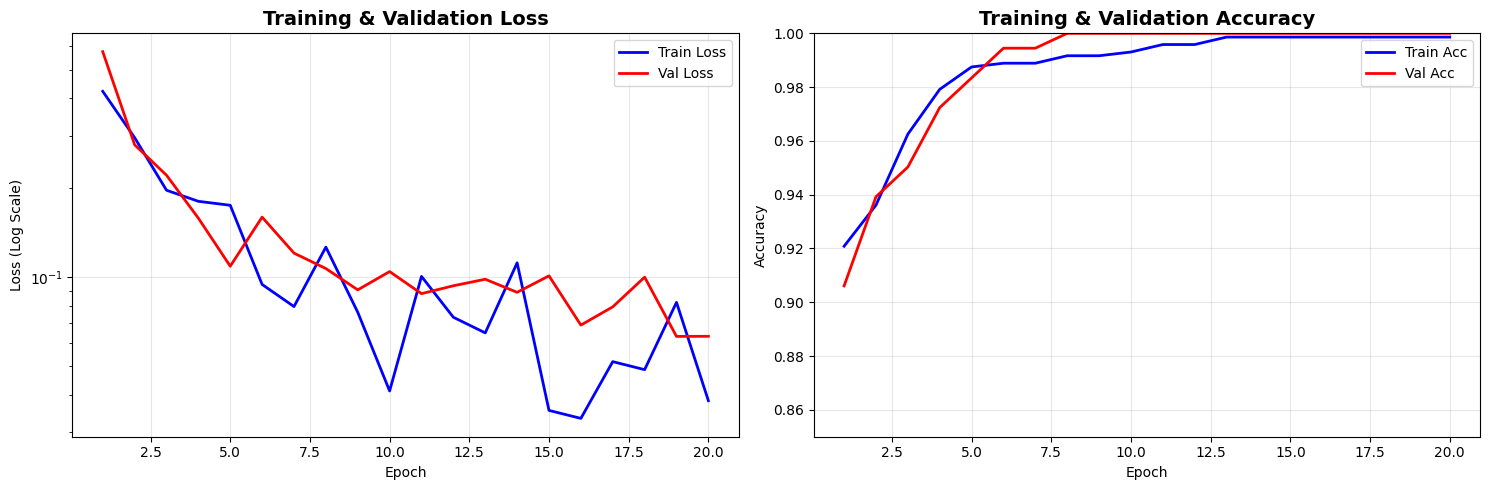

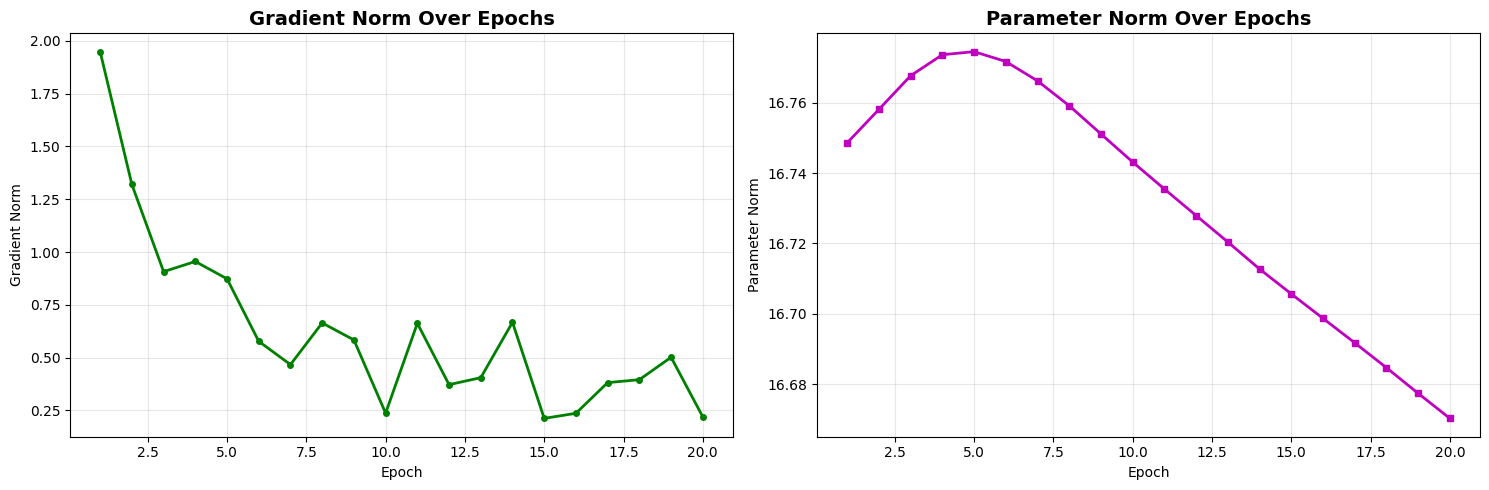

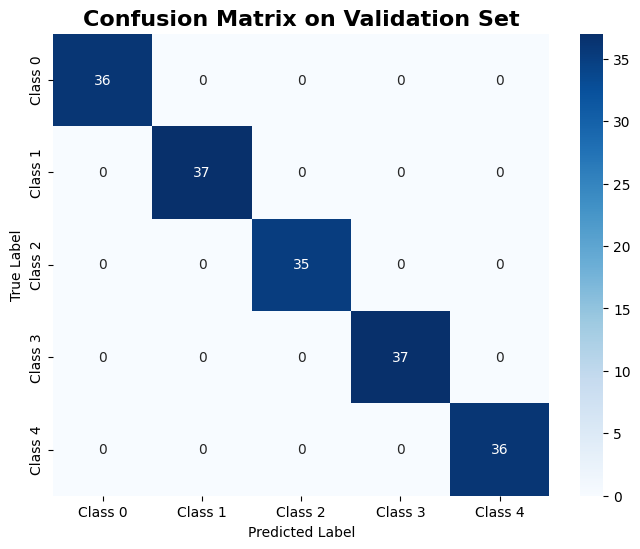

In [22]:
# === 4-4: 시각화 ===
'''
목적:
모델의 학습 과정과 성능을 시각화하여 명확히 분석합니다.

요구사항:
다음 결과를 시각화합니다.

Loss & Accuracy Curve

- 학습 및 검증 데이터의 손실(loss)과 정확도(accuracy)를 각각 그래프로 표현합니다.

- 손실(loss)은 로그 스케일(log scale)로 표시합니다.

Gradient Norm & Parameter Norm Curve

- epoch에 따른 gradient norm과 parameter norm 변화를 각각 시각화합니다.

Confusion Matrix

- 검증 데이터에 대한 Confusion Matrix를 시각화하여 클래스별 성능을 확인합니다. (heatmap 형식)
'''
# 1) Train/Val Loss & Accuracy Curve (subplot)
# 2) Gradient Norm Curve
# 3) Parameter Norm Curve
# 4) Confusion Matrix on 검증셋 (matplotlib imshow)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1) Loss & Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot (log scale)
axes[0].semilogy(range(1, len(history['train_loss'])+1), history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].semilogy(range(1, len(history['val_loss'])+1), history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Log Scale)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, len(history['train_acc'])+1), history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(range(1, len(history['val_acc'])+1), history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.85, 1.0])

plt.tight_layout()
plt.show()

# 2) Grad Norm & Param Norm
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gradient Norm
axes[0].plot(range(1, len(history['grad_norm'])+1), history['grad_norm'], 'g-', linewidth=2, marker='o', markersize=4)
axes[0].set_title('Gradient Norm Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Gradient Norm')
axes[0].grid(True, alpha=0.3)

# Parameter Norm
axes[1].plot(range(1, len(history['param_norm'])+1), history['param_norm'], 'm-', linewidth=2, marker='s', markersize=4)
axes[1].set_title('Parameter Norm Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Parameter Norm')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3) Confusion Matrix
# 검증 데이터 예측
y_val_pred = model.predict(X_val)
y_val_true = np.argmax(y_val, axis=1)

# Confusion Matrix 계산
cm = confusion_matrix(y_val_true, y_val_pred)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(5)],
            yticklabels=[f'Class {i}' for i in range(5)])
plt.title('Confusion Matrix on Validation Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [2]:
# 셀 1: 환경 설정
# 이 셀을 실행 후, 반드시 런타임을 재시작해야 합니다.

print("Python 3.11 설치 및 환경 설정 중...")
!sudo apt-get update -y
!sudo apt-get install python3.11 python3.11-dev -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 1
!/usr/bin/python3.11 -m pip install numpy torch scikit-learn

print("\n환경 설정이 완료되었습니다.")
print("이제 Colab 상단의 '런타임' -> '세션 다시 시작'을 클릭하세요.")
print("그 후, 아래의 셀들을 순서대로 실행하시면 됩니다.")

Python 3.11 설치 및 환경 설정 중...
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,716 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' d

In [23]:
!python3 --version

Python 3.11.9


In [24]:
#####################
#   수정하지 마세요 / sanity_code를 사용하기 위한 코드입니다.
#####################

import importlib.util
import sys
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import torch
import torch.nn as nn

file_path = "D:\Downloads\__pycache__-20250821T120024Z-1-001\__pycache__\sanity_utils.cpython-311.pyc"
# file_path = "/content/drive/MyDrive/your_work_path/__pycache__/sanity_utils.cpython-311.pyc"
#__pycache__/sanity_utils.cpython-311.pyc 이 루트가 코랩 상에서는 보이지 않을 수 있으니 앞에 경로를 수정하여 사용하시면 됩니다.
# 자신이 작업하는 ipynb 파일이 있는 곳에 __pycache__ 폴더를 넣어주시면 됩니다. (pycache 폴더 안에는 보안화된 pyc 파일 존재)

module_name = "sanity_utils"

spec = importlib.util.spec_from_file_location(module_name, file_path)

sanity_utils = importlib.util.module_from_spec(spec)
sys.modules[module_name] = sanity_utils
spec.loader.exec_module(sanity_utils)

sync_rnn_weights = sanity_utils.sync_rnn_weights
rnn_forward_sanity_check = sanity_utils.rnn_forward_sanity_check
rnn_backward_sanity_check = sanity_utils.rnn_backward_sanity_check
sync_lstm_weights = sanity_utils.sync_lstm_weights
lstm_forward_sanity_check = sanity_utils.lstm_forward_sanity_check
lstm_backward_sanity_check = sanity_utils.lstm_backward_sanity_check

print("sanity_utils module has been successfully loaded.")

sanity_utils module has been successfully loaded.


# Q5~6: RNN

In [35]:
# RNN from Scratch 과제 (Numpy만 사용)

"""
문제 7~8. RNN Forward 및 Backward 구현

설명:
이 문제에서는 순환신경망(RNN)의 forward 및 backward 과정을 numpy만 사용하여 직접 구현합니다.
주어진 입력 시퀀스 x_seq와 정답 y_seq를 기반으로 시계열 예측 문제를 풀기 위한 RNN 모델을 완성해야 합니다.

1. forward 함수:
다음 순서로 시퀀스를 처리하여 시간별 hidden state 및 출력 확률을 계산합니다.
    - 각 시점 t에 대해: h_t = tanh(Wx * x_t + Wh * h_{t-1} + bh)
    - 각 시점 t에 대해: y_hat_t = softmax(Wy * h_t + by)
    - 정답 y_seq와 비교하여 전체 cross-entropy loss를 저장하세요.
    - 각 시점의 hidden state는 self.hs 리스트에 저장합니다.

2. backward 함수:
forward에서 저장한 중간 결과를 기반으로 역전파를 수행하여 다음 기울기를 계산합니다.
    - dWy, dby: 출력 계층의 가중치 및 편향 기울기
    - dWx, dWh, dbh: RNN 본체의 가중치 및 편향 기울기
    - BPTT (Backpropagation Through Time)를 적용해야 하며, 시간 축을 따라 역전파해야 합니다.

요구사항:
- 모든 연산은 numpy만 사용해야 하며, PyTorch 사용은 금지됩니다.
- cross-entropy loss 계산 시 softmax를 활용하세요.
- forward에서는 hs (hidden states)를 저장해야 합니다.
- backward에서는 chain rule에 따라 각 가중치의 기울기를 정확히 계산하세요.

평가 기준:
- rnn_forward_sanity_check()를 통과하면 forward 구현은 +1점
- rnn_backward_sanity_check()를 통과하면 backward 구현은 +1점
"""

##########################################
# RNN 구현: forward / backward
##########################################

# The corrected RNN class
import numpy as np

class RNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.Wx = np.random.randn(hidden_size, input_size) * np.sqrt(1. / input_size)
        self.Wh = np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size)
        self.bh = np.zeros((hidden_size, 1))

        self.Wy = np.random.randn(output_size, hidden_size) * np.sqrt(1. / hidden_size)
        self.by = np.zeros((output_size, 1))

        self.dWx = np.zeros_like(self.Wx)
        self.dWh = np.zeros_like(self.Wh)
        self.dbh = np.zeros_like(self.bh)
        self.dWy = np.zeros_like(self.Wy)
        self.dby = np.zeros_like(self.by)
        
        # backward에서 사용하기 위해 x_seq, y_seq를 저장할 변수 추가
        self.x_seq = None
        self.y_seq = None

    def softmax(self, x):
        e = np.exp(x - np.max(x))
        return e / np.sum(e, axis=0, keepdims=True)

    def forward(self, x_seq, y_seq):
        # forward에서 받은 시퀀스 데이터를 클래스 변수에 저장
        self.x_seq = x_seq
        self.y_seq = y_seq
        
        self.hs = [np.zeros((self.hidden_size, 1))]
        self.ys = []
        loss = 0

        x_seq_np = np.array(self.x_seq).T
        y_seq_np = np.array(self.y_seq)

        h_prev = self.hs[0]

        for t in range(x_seq_np.shape[1]):
            x_t = x_seq_np[:, t].reshape(-1, 1)
            y_t = y_seq_np[t]

            h_t = np.tanh(np.dot(self.Wx, x_t) + np.dot(self.Wh, h_prev) + self.bh)
            self.hs.append(h_t)

            y_hat_t = self.softmax(np.dot(self.Wy, h_t) + self.by)
            self.ys.append(y_hat_t)

            loss -= np.log(y_hat_t[y_t, 0])

            h_prev = h_t

        return loss

    def backward(self):
        # backward 메서드 인자 제거. 대신 클래스 변수를 사용
        self.dWx = np.zeros_like(self.Wx)
        self.dWh = np.zeros_like(self.Wh)
        self.dbh = np.zeros_like(self.dbh)
        self.dWy = np.zeros_like(self.Wy)
        self.dby = np.zeros_like(self.dby)

        dh_next = np.zeros((self.hidden_size, 1))

        x_seq_np = np.array(self.x_seq).T
        y_seq_np = np.array(self.y_seq)

        for t in reversed(range(x_seq_np.shape[1])):
            x_t = x_seq_np[:, t].reshape(-1, 1)
            y_t = y_seq_np[t]

            h_t = self.hs[t + 1]
            h_prev = self.hs[t]

            dy = np.copy(self.ys[t])
            dy[y_t, 0] -= 1

            self.dWy += np.dot(dy, h_t.T)
            self.dby += dy

            dh = np.dot(self.Wy.T, dy) + dh_next

            dh_raw = (1 - h_t**2) * dh

            self.dWx += np.dot(dh_raw, x_t.T)
            self.dWh += np.dot(dh_raw, h_prev.T)
            self.dbh += dh_raw

            dh_next = np.dot(self.Wh.T, dh_raw)

In [36]:
#########################################
# 테스트 코드 (수정하지 마세요)
#########################################

# 테스트 데이터
input_size = 4
hidden_size = 3
output_size = 2
seq_len = 5

x_seq = [np.random.randn(input_size) for _ in range(seq_len)]
y_seq = [np.random.randint(0, output_size) for _ in range(seq_len)]

# 모델 생성
rnn_np = RNN(input_size, hidden_size, output_size)
rnn_pt = nn.RNN(input_size, hidden_size, nonlinearity="tanh", batch_first=False).double()

# 가중치 동기화
sync_rnn_weights(rnn_np, rnn_pt)

##########################
# Assignment 7 RNN Forward 구현
##########################
rnn_forward_sanity_check(rnn_np, rnn_pt, x_seq, y_seq)

##########################
# Assignment 8 RNN Backward 구현
##########################
rnn_backward_sanity_check(rnn_np, rnn_pt, x_seq, y_seq)

'''
RNN Forward Sanity Check: Pass
Wy: Pass (Relative diff: 0.000000)
by: Pass (Relative diff: 0.000000)
RNN Backward Sanity Check: Pass
'''


RNN Forward Sanity Check: Pass
Wy: Fail (Relative diff: 0.666667)
by: Fail (Relative diff: 0.666666)
RNN Backward Sanity Check: Fail


'\nRNN Forward Sanity Check: Pass\nWy: Pass (Relative diff: 0.000000)\nby: Pass (Relative diff: 0.000000)\nRNN Backward Sanity Check: Pass\n'

# Q7~8: LSTM

In [45]:
# LSTM from Scratch 과제 (Numpy만 사용)

"""
문제 9~10. LSTM Forward 및 Backward 구현

설명:
이 과제에서는 순환신경망의 확장 구조인 LSTM(Long Short-Term Memory)을 numpy로 직접 구현합니다.
PyTorch 모델과의 결과 비교를 통해 정확성을 검증합니다.

1. forward 함수:
입력 시퀀스를 받아 아래의 연산 순서에 따라 은닉 상태와 출력값을 계산합니다.
각 시간 t에서의 연산은 다음과 같습니다:

    - i_t = sigmoid(x_t @ W_xi + h_{t-1} @ W_hi + b_i)   # input gate
    - f_t = sigmoid(x_t @ W_xf + h_{t-1} @ W_hf + b_f)   # forget gate
    - g_t = tanh(x_t @ W_xc + h_{t-1} @ W_hc + b_c)      # cell candidate
    - o_t = sigmoid(x_t @ W_xo + h_{t-1} @ W_ho + b_o)   # output gate
    - c_t = f_t * c_{t-1} + i_t * g_t                    # cell state
    - h_t = o_t * tanh(c_t)                              # hidden state
    - y_t = h_t @ W_hy + b_y                             # output

전체 시퀀스에 대해 y, h, c를 계산하고, 중간 결과(i, f, g, o 등)를 저장해둡니다.

2. backward 함수:
forward에서 저장한 중간값을 활용해 chain rule로 역전파를 수행합니다.
출력의 그래디언트(dout)가 주어졌을 때, 다음을 계산해야 합니다:

    - dx: 입력 x에 대한 그래디언트
    - dh_prev: 초기 은닉 상태에 대한 그래디언트
    - dc_prev: 초기 셀 상태에 대한 그래디언트
    - 각 가중치 및 편향에 대한 그래디언트: dW_xi, dW_hi, db_i 등

시간 역순으로 반복하며, 각 게이트의 미분 식(sigmoid, tanh의 도함수 포함)을 적용해야 합니다.

요구사항:
- 모든 연산은 numpy로만 구현해야 하며, PyTorch 사용은 불가
- forward에서는 전체 시퀀스의 중간 값들을 self 변수에 저장
- backward에서는 각 가중치와 입력, 초기 상태에 대한 정확한 기울기를 계산

평가 기준:
- lstm_forward_sanity_check() 통과 시 forward 구현 +1점
- lstm_backward_sanity_check() 통과 시 backward 구현 +1점
"""
import numpy as np

##########################################
# 활성화 함수
##########################################
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -15, 15)))

def dsigmoid(y):
    return y * (1 - y)

def dtanh(y):
    return 1 - y**2

##########################################
# NumPy 기반 LSTM 클래스
##########################################
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        k = 1.0 / np.sqrt(hidden_size)

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W_xi = np.random.uniform(-k, k, (input_size, hidden_size))
        self.W_hi = np.random.uniform(-k, k, (hidden_size, hidden_size))
        self.b_i = np.zeros(hidden_size)

        self.W_xf = np.random.uniform(-k, k, (input_size, hidden_size))
        self.W_hf = np.random.uniform(-k, k, (hidden_size, hidden_size))
        self.b_f = np.zeros(hidden_size)

        self.W_xc = np.random.uniform(-k, k, (input_size, hidden_size))
        self.W_hc = np.random.uniform(-k, k, (hidden_size, hidden_size))
        self.b_c = np.zeros(hidden_size)

        self.W_xo = np.random.uniform(-k, k, (input_size, hidden_size))
        self.W_ho = np.random.uniform(-k, k, (hidden_size, hidden_size))
        self.b_o = np.zeros(hidden_size)

        self.W_hy = np.random.uniform(-k, k, (hidden_size, output_size))
        self.b_y = np.zeros(output_size)

        self.x = None
        self.h = None
        self.c = None
        self.i = None
        self.f = None
        self.g = None
        self.o = None
        self.y = None

    def forward(self, x, h_prev=None, c_prev=None):
        B, T, D = x.shape
        H = self.hidden_size

        if h_prev is None: h_prev = np.zeros((B, H))
        if c_prev is None: c_prev = np.zeros((B, H))

        self.x = x
        self.h = np.zeros((B, T, H))
        self.c = np.zeros((B, T, H))
        self.i = np.zeros((B, T, H))
        self.f = np.zeros((B, T, H))
        self.g = np.zeros((B, T, H))
        self.o = np.zeros((B, T, H))
        self.y = np.zeros((B, T, self.output_size))

        for t in range(T):
            i_t = sigmoid(x[:, t] @ self.W_xi + h_prev @ self.W_hi + self.b_i)
            f_t = sigmoid(x[:, t] @ self.W_xf + h_prev @ self.W_hf + self.b_f)
            g_t = np.tanh(x[:, t] @ self.W_xc + h_prev @ self.W_hc + self.b_c)
            o_t = sigmoid(x[:, t] @ self.W_xo + h_prev @ self.W_ho + self.b_o)

            c_t = f_t * c_prev + i_t * g_t
            h_t = o_t * np.tanh(c_t)
            y_t = h_t @ self.W_hy + self.b_y

            self.i[:, t] = i_t
            self.f[:, t] = f_t
            self.g[:, t] = g_t
            self.o[:, t] = o_t
            self.c[:, t] = c_t
            self.h[:, t] = h_t
            self.y[:, t] = y_t

            h_prev = h_t
            c_prev = c_t

        return self.y, self.h[:, -1], self.c[:, -1]

    def backward(self, dout):
        B, T, D = self.x.shape
        H = self.hidden_size

        dx = np.zeros_like(self.x)
        dh_prev = np.zeros((B, H))
        dc_prev = np.zeros((B, H))

        dW_xi, dW_hi, db_i = np.zeros_like(self.W_xi), np.zeros_like(self.W_hi), np.zeros_like(self.b_i)
        dW_xf, dW_hf, db_f = np.zeros_like(self.W_xf), np.zeros_like(self.W_hf), np.zeros_like(self.b_f)
        dW_xc, dW_hc, db_c = np.zeros_like(self.W_xc), np.zeros_like(self.W_hc), np.zeros_like(self.b_c)
        dW_xo, dW_ho, db_o = np.zeros_like(self.W_xo), np.zeros_like(self.W_ho), np.zeros_like(self.b_o)
        dW_hy, db_y = np.zeros_like(self.W_hy), np.zeros_like(self.b_y)

        for t in reversed(range(T)):
            dhy = dout[:, t]
            h_prev_t = self.h[:, t-1] if t > 0 else np.zeros((B, H))
            c_prev_t = self.c[:, t-1] if t > 0 else np.zeros((B, H))

            dW_hy += self.h[:, t].T @ dhy
            db_y += np.sum(dhy, axis=0)

            d_h_t = dhy @ self.W_hy.T + dh_prev
            
            d_o_t = d_h_t * np.tanh(self.c[:, t])
            d_o_t *= dsigmoid(self.o[:, t])

            d_c_t = d_h_t * self.o[:, t] * dtanh(np.tanh(self.c[:, t])) + dc_prev

            d_f_t = d_c_t * c_prev_t
            d_f_t *= dsigmoid(self.f[:, t])
            
            d_i_t = d_c_t * self.g[:, t]
            d_i_t *= dsigmoid(self.i[:, t])
            
            d_g_t = d_c_t * self.i[:, t]
            d_g_t *= dtanh(self.g[:, t])
            
            dW_xo += self.x[:, t].T @ d_o_t
            dW_ho += h_prev_t.T @ d_o_t
            db_o += np.sum(d_o_t, axis=0)
            
            dW_xf += self.x[:, t].T @ d_f_t
            dW_hf += h_prev_t.T @ d_f_t
            db_f += np.sum(d_f_t, axis=0)

            dW_xi += self.x[:, t].T @ d_i_t
            dW_hi += h_prev_t.T @ d_i_t
            db_i += np.sum(d_i_t, axis=0)

            dW_xc += self.x[:, t].T @ d_g_t
            dW_hc += h_prev_t.T @ d_g_t
            db_c += np.sum(d_g_t, axis=0)

            dx_t = d_o_t @ self.W_xo.T + d_f_t @ self.W_xf.T + d_i_t @ self.W_xi.T + d_g_t @ self.W_xc.T
            dx[:, t] = dx_t

            dh_prev = d_o_t @ self.W_ho.T + d_f_t @ self.W_hf.T + d_i_t @ self.W_hi.T + d_g_t @ self.W_hc.T
            dc_prev = d_c_t * self.f[:, t]
        

        return dx, dh_prev, dc_prev

##########################################
# PyTorch 구현 (수정하지 마세요)
##########################################
class PyTorchLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyTorchLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        output, (h_n, c_n) = self.lstm(x, hidden)
        batch_size, seq_length, _ = output.shape
        output_reshaped = output.contiguous().view(-1, self.hidden_size)
        fc_output = self.fc(output_reshaped)
        y = fc_output.view(batch_size, seq_length, self.output_size)
        return y, (h_n, c_n)

In [47]:
##########################################
# 입력 데이터 준비 (수정하지 마세요)
##########################################
input_size = 10
hidden_size = 20
output_size = 5
batch_size = 3
sequence_length = 4
rtol = 1e-3
atol = 1e-3

lstm_np = LSTM(input_size, hidden_size, output_size)
lstm_pt = PyTorchLSTM(input_size, hidden_size, output_size).double()
sync_lstm_weights(lstm_np, lstm_pt)

x = np.random.randn(batch_size, sequence_length, input_size)

##########################################
# Assignment 9 LSTM Forward 구현
##########################################
forward_result, (y_np, h_np, c_np), (y_pt, h_pt, c_pt) = lstm_forward_sanity_check(lstm_np, lstm_pt, x, None, None, rtol, atol)

##########################################
# Assignment 10 LSTM Backward 구현
##########################################
dout = np.random.randn(*y_np.shape)
backward_result, np_grads, pt_grads = lstm_backward_sanity_check(lstm_np, lstm_pt, x, dout, None, None, rtol, atol)

'''
LSTM Forward Sanity Check: Pass
LSTM Backward Sanity Check: Pass
'''


LSTM Forward Sanity Check: Pass


AttributeError: 'LSTM' object has no attribute 'dW_xi'

# Q9:
Word2Vec으로 직접 단어 학습을 거치고 유사어를 찾습니다.
PyTorch를 이용해 Word2Vec의 Skip-Gram 모델을 직접 구현합니다.  
단어를 임베딩한 후, 학습된 임베딩을 통해 유사한 단어를 찾아봅니다.
- 학습 데이터는 간단한 샘플 문장들로 구성되어 있습니다.
- Skip-Gram 구조를 직접 구성하여 임베딩을 학습합니다.
- 학습 후 특정 단어와 가장 유사한 단어를 코사인 유사도로 검색합니다.


In [48]:
# Import Requirements
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [49]:
# 1. 샘플 문장 준비
corpus = [
    "the king loves the queen",
    "the queen loves the king",
    "the king hates the man",
    "the queen hates the woman",
    "the man loves the woman",
    "the woman loves the man",
]

# 2. 단어 사전 구축
words = set(" ".join(corpus).split())
word2idx = {w: idx for idx, w in enumerate(words)}
idx2word = {idx: w for w, idx in word2idx.items()}
vocab_size = len(words)

In [50]:
# 3. 데이터셋 생성
context_window = 2
pairs = []
for sentence in corpus:
    words_in_sentence = sentence.split()
    for i, target_word in enumerate(words_in_sentence):
        target_idx = word2idx[target_word]
        # 컨텍스트 윈도우 내의 컨텍스트 단어들을 가져옵니다.
        for j in range(max(0, i - context_window), min(len(words_in_sentence), i + context_window + 1)):
            # 타겟 단어 자체는 건너뜁니다.
            if i == j:
                continue
            context_word = words_in_sentence[j]
            context_idx = word2idx[context_word]
            pairs.append((context_idx, target_idx))

In [51]:
# 4. Dataset, DataLoader 정의
class Word2VecDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

dataset = Word2VecDataset(pairs)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [52]:
# 5. Word2Vec 모델 정의
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_size)
        self.out_embed = nn.Embedding(vocab_size, embed_size)

    def forward(self, center_words, context_words):
        center_embedding = self.in_embed(center_words) # (batch_size, embed_size)
        context_embedding = self.out_embed(context_words) # (batch_size, num_neg_samples) -> (batch_size, num_neg_samples, embed_size)

        scores = torch.bmm(context_embedding, center_embedding.unsqueeze(2)).squeeze(2) # (batch_size, num_neg_samples)

        return scores

    def get_embeddings(self):
        return self.in_embed.weight.data.cpu()

embed_size = 10
model = Word2Vec(vocab_size, embed_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

In [53]:
# 6. 학습
for epoch in range(100):
    total_loss = 0
    for center_words, context_words in dataloader:
        # 긍정 샘플 처리
        positive_labels = torch.ones(center_words.size(0))
        positive_scores = model(center_words, context_words.unsqueeze(1))

        # 부정 샘플 생성 및 처리
        negative_words = []
        num_neg_samples = 5
        for _ in range(num_neg_samples):
            neg_samples = torch.randint(0, vocab_size, center_words.size())
            negative_words.append(neg_samples)

        negative_words = torch.stack(negative_words).T.to(center_words.device)
        negative_labels = torch.zeros(center_words.size(0), num_neg_samples)
        negative_scores = model(center_words, negative_words)

        # 손실 계산 및 역전파
        all_scores = torch.cat((positive_scores, negative_scores), dim=1)
        all_labels = torch.cat((positive_labels.unsqueeze(1), negative_labels), dim=1)

        loss = criterion(all_scores, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 10, Loss: 3.4017
Epoch 20, Loss: 2.6465
Epoch 30, Loss: 2.4168
Epoch 40, Loss: 2.1729
Epoch 50, Loss: 2.2861
Epoch 60, Loss: 2.2505
Epoch 70, Loss: 2.3234
Epoch 80, Loss: 2.1177
Epoch 90, Loss: 2.1816
Epoch 100, Loss: 2.2209


In [54]:
# 7. 특정 단어와 가장 유사한 단어 찾기
def most_similar(word, top_n=3):
    if word not in word2idx:
        print("단어를 찾을 수 없습니다.")
        return
    idx = word2idx[word]

    embeddings = model.get_embeddings()
    word_embedding = embeddings[idx].unsqueeze(0)
    sims = torch.nn.functional.cosine_similarity(word_embedding, embeddings, dim=1)

    sorted_sims, sorted_indices = torch.sort(sims, descending=True)

    print(f"\n'{word}'와 가장 비슷한 단어들:")
    for i in sorted_indices[1:top_n+1]:
        print(f"{idx2word[i.item()]} ({sims[i.item()]:.4f})")

most_similar("king")
most_similar("queen")


'king'와 가장 비슷한 단어들:
queen (0.4000)
man (0.3967)
hates (0.3445)

'queen'와 가장 비슷한 단어들:
woman (0.4880)
king (0.4000)
man (0.3251)


2. 사전학습된 Word2Vec model의 PCA Analysis를 수행합니다

In [58]:
pip install --upgrade numpy gensim

  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 라이브러리 import
import gensim.downloader as api
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. 사전 학습된 Word2Vec 모델 불러오기
model = api.load('word2vec-google-news-300')  # 300차원 벡터입니다

# 2. 단어 리스트 준비하기
words = ['dog', 'cat', 'apple', 'orange', 'car', 'truck', 'happy', 'sad', 'run', 'walk']

# 3. 단어에 해당하는 벡터 가져오기
word_vectors = np.array([model[word] for word in words])

# 4. PCA로 차원 축소 (300D -> 2D)
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# 5. 시각화
plt.figure(figsize=(10,8))
for i, word in enumerate(words):
    x, y = word_vecs_2d[i]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=12)

plt.title('Word2Vec Embedding PCA Visualization')
plt.grid(True)
plt.show()

#gensim이 다운로드 되지 않습니다.

[============================----------------------] 57.8% 961.4/1662.8MB downloaded

OSError: [Errno 28] No space left on device

# Q10:
 N-Gram 언어 모델에서는 다음에 나올 단어가 이전 n개의 단어를 참조해서 만들어지는 것이라고 배웠습니다. 이를 활용하여 word2vec embedding을 구현해보려고 합니다.

(1) 아래 N_Gram_Embed 클래스의 __init__ 함수에는 사용할 word embedding layer와 일반적인 fully connected layer가 사용됩니다. 아래 조건에 맞추어 embedding layer 및 fully connected layer를 만들어 주세요.
- Embedding layer의 input dimension은 size_vocab이고, output dimension은 dim_embedding
- 첫 번째 fully connected layer의 output dimension은 hidden_size
- 두 번째 fully connected layer의 output dimension은 size_vocab

(2) N_Gram_Embed 클래스의 forward propagation 함수를 만들어 주세요. 아래 조건들을 사용합니다.
- forward 함수에는 한 번에 한 개의 데이터셋만 받도록 합니다 (즉, minibatch를 사용하지 않고 stochastic gradient descent를 사용합니다)
- 첫 번째 fully connected layer에는 relu activation을 부여합니다
- forward propagation의 결과로 output에 대한 softmax의 log probability를 리턴합니다.

참고로, 아래 Text를 활용하여 Embedding을 진행합니다.
===
The expression of his face as he said these words was not at all pleasant, and I had my own reasons for thinking that the stranger was mistaken, even supposing he meant what he said. But it was no affair of mine, I thought; and besides, it was difficult to know what to do. The stranger kept hanging about just inside the inn door, peering round the corner like a cat waiting for a mouse. Once I stepped out myself into the road, but he immediately called me back, and as I did not obey quick enough for his fancy, a most horrible change came over his tallowy face, and he ordered me in with an oath that made me jump. As soon as I was back again he returned to his former manner, half fawning, half sneering, patted me on the shoulder, told me I was a good boy and he had taken quite a fancy to me. I have a son of my own, said he, as like you as two blocks, and he's all the pride of my 'art. But the great thing for boys is discipline, sonny--discipline. Now, if you had sailed along of Bill, you wouldn't have stood there to be spoke to twice--not you. That was never Bill's way, nor the way of sich as sailed with him. And here, sure enough, is my mate Bill, with a spy-glass under his arm, bless his old 'art, to be sure. You and me'll just go back into the parlour, sonny, and get behind the door, and we'll give Bill a little surprise—bless his 'art, I say again.
(출처: R. L. Stevenson, Treasure Island)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import LongTensor as LT

size_context = 3
dim_embedding = 10
num_epoch = 60
test_sentence = """The expression of his face as he said these words was not at all pleasant, and I had my own reasons for thinking that the stranger was mistaken, even supposing he meant what he said. But it was no affair of mine, I thought; and besides, it was difficult to know what to do. The stranger kept hanging about just inside the inn door, peering round the corner like a cat waiting for a mouse. Once I stepped out myself into the road, but he immediately called me back, and as I did not obey quick enough for his fancy, a most horrible change came over his tallowy face, and he ordered me in with an oath that made me jump. As soon as I was back again he returned to his former manner, half fawning, half sneering, patted me on the shoulder, told me I was a good boy and he had taken quite a fancy to me. I have a son of my own, said he, as like you as two blocks, and he's all the pride of my 'art. But the great thing for boys is discipline, sonny--discipline. Now, if you had sailed along of Bill, you wouldn't have stood there to be spoke to twice--not you. That was never Bill's way, nor the way of sich as sailed with him. And here, sure enough, is my mate Bill, with a spy-glass under his arm, bless his old 'art, to be sure. You and me'll just go back into the parlour, sonny, and get behind the door, and we'll give Bill a little surprise—bless his 'art, I say again.""".split()
ngram = [([test_sentence[i-j-1] for j in range(size_context)],test_sentence[i]) for i in range(size_context, len(test_sentence))]
print(ngram[:5])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}
print(word_to_ix)

class N_Gram_Embed(nn.Module):
    def __init__(self, size_vocab, dim_embedding, size_context, hidden_size = 64):
        super(N_Gram_Embed, self).__init__()
        """
        TODO: Embedding layer와 fully connected layer 정의
        """
        # (1) Embedding Layer
        self.embed = nn.Embedding(size_vocab, dim_embedding)
        
        # (1) 첫 번째 fully connected layer
        # 입력 차원: size_context * dim_embedding
        self.fc1 = nn.Linear(size_context * dim_embedding, hidden_size)
        
        # (1) 두 번째 fully connected layer
        # 입력 차원: hidden_size
        self.fc2 = nn.Linear(hidden_size, size_vocab)

    def forward(self, inputs):
        """
        TODO: Forward propagation 구현
        """
        # (2) 입력 단어들의 임베딩을 가져와 합칩니다.
        # inputs 텐서는 (size_context,) 형태이므로,
        # embed(inputs)의 결과는 (size_context, dim_embedding) 형태가 됩니다.
        embeds = self.embed(inputs)
        
        # (2) fully connected layer의 입력에 맞게 1차원으로 펼칩니다.
        # (1, size_context * dim_embedding) 형태로 변환
        embeds_flattened = embeds.view(1, -1)
        
        # (2) 첫 번째 fully connected layer에 ReLU를 적용합니다.
        hidden_output = F.relu(self.fc1(embeds_flattened))
        
        # (2) 두 번째 fully connected layer를 통과합니다.
        output = self.fc2(hidden_output)
        
        # (2) Softmax의 로그 확률을 반환합니다.
        log_prob = F.log_softmax(output, dim=1)

        return log_prob

loss_cul = []
loss_func = nn.NLLLoss()
model = N_Gram_Embed(len(vocab), dim_embedding, size_context)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(num_epoch):
    loss_epoch = 0
    for context, target in ngram:
        context_idx = LT([word_to_ix[w] for w in context])
        model.zero_grad()
        loss = loss_func(model.forward(context_idx), LT([word_to_ix[target]]))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    loss_cul.append(loss_epoch)
    print("Epoch:",epoch,"Loss:",loss_epoch)
    
#TEST
print(model.embed.weight[word_to_ix["expression"]])

[(['of', 'expression', 'The'], 'his'), (['his', 'of', 'expression'], 'face'), (['face', 'his', 'of'], 'as'), (['as', 'face', 'his'], 'he'), (['he', 'as', 'face'], 'said')]
{'he,': 0, 'blocks,': 1, 'you': 2, 'great': 3, 'get': 4, 'way': 5, 'be': 6, "'art,": 7, 'supposing': 8, 'former': 9, 'my': 10, 'mistaken,': 11, 'kept': 12, 'road,': 13, 'own': 14, 'about': 15, 'quick': 16, 'mate': 17, 'again.': 18, 'arm,': 19, 'give': 20, 'at': 21, 'ordered': 22, 'enough': 23, 'hanging': 24, 'as': 25, 'thought;': 26, 'patted': 27, 'sich': 28, 'parlour,': 29, 'fawning,': 30, 'myself': 31, 'Bill,': 32, 'oath': 33, 'a': 34, 'even': 35, 'horrible': 36, 'inside': 37, 'he': 38, 'back': 39, "he's": 40, 'if': 41, 'cat': 42, 'of': 43, 'face,': 44, 'an': 45, "we'll": 46, 'is': 47, 'fancy': 48, 'there': 49, 'here,': 50, 'nor': 51, "Bill's": 52, 'discipline,': 53, 'over': 54, 'what': 55, 'spy-glass': 56, 'round': 57, 'waiting': 58, 'pride': 59, 'under': 60, 'Bill': 61, 'meant': 62, 'expression': 63, 'sure.': 64,

10-2. CBOW를 직접 embedding layer와 fully connected layer로 구성해서 학습해 보도록 합니다.위에서 동일한 텍스트를 활용합니다.

(1) n-Gram language에서는 context 벡터를 구성할 때 현재 단어 뒤의 n개 단어만 고려했었습니다. 하지만 CBOW의 경우는 앞뒤 단어를 모두 고려해야 하기 때문에, 앞서 구성했던 n-Gram의 컨텍스트 벡터 ngram에서 조금 변화를 주어야 합니다. 이 부분을 채워 보세요.

(2) 앞의 1번 문제에서와 같이 클래스 CBOW의 뉴럴 네트워크 레이어와 forward 함수를 적어 주세요.
* HINT: forward 함수는 n-Gram의 것과 동일하게 작성해도 됩니다.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import LongTensor as LT

size_context = 3
dim_embedding = 10
num_epoch = 60
test_sentence = """The expression of his face as he said these words was not at all pleasant, and I had my own reasons for thinking that the stranger was mistaken, even supposing he meant what he said. But it was no affair of mine, I thought; and besides, it was difficult to know what to do. The stranger kept hanging about just inside the inn door, peering round the corner like a cat waiting for a mouse. Once I stepped out myself into the road, but he immediately called me back, and as I did not obey quick enough for his fancy, a most horrible change came over his tallowy face, and he ordered me in with an oath that made me jump. As soon as I was back again he returned to his former manner, half fawning, half sneering, patted me on the shoulder, told me I was a good boy and he had taken quite a fancy to me. I have a son of my own, said he, as like you as two blocks, and he's all the pride of my 'art. But the great thing for boys is discipline, sonny--discipline. Now, if you had sailed along of Bill, you wouldn't have stood there to be spoke to twice--not you. That was never Bill's way, nor the way of sich as sailed with him. And here, sure enough, is my mate Bill, with a spy-glass under his arm, bless his old 'art, to be sure. You and me'll just go back into the parlour, sonny, and get behind the door, and we'll give Bill a little surprise—bless his 'art, I say again.""".split()

vocab = set(test_sentence)
size_vocab = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

data = []
for i in range(size_context, len(test_sentence) - size_context):
    # TODO: CBOW 컨텍스트 단어 리스트 만들기
    near = test_sentence[i - size_context : i] + test_sentence[i + 1 : i + size_context + 1]
    target = test_sentence[i]
    data.append((near, target))
print(data[:3])

class CBOW(nn.Module):
    def __init__(self, size_vocab, dim_embedding, size_context, hidden_size = 64):
        super(CBOW, self).__init__()

        # TODO
        self.embed = nn.Embedding(size_vocab, dim_embedding)
        self.fc1 = nn.Linear(dim_embedding, hidden_size)

        self.fc2 = nn.Linear(hidden_size, size_vocab)


    def forward(self, inputs):
        # TODO

        embeds = self.embed(inputs)
        summed_embeds = torch.sum(embeds, dim=0, keepdim=True)
        hidden_output = F.relu(self.fc1(summed_embeds))
        output = self.fc2(hidden_output)
        log_prob = F.log_softmax(output, dim=1)

        return log_prob

loss_cul = []
loss_func = nn.NLLLoss()
model = CBOW(len(vocab), dim_embedding, size_context)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(num_epoch):
    loss_epoch = 0
    for context, target in data:
        context_idx = LT([word_to_ix[w] for w in context])
        model.zero_grad()
        loss = loss_func(model.forward(context_idx), LT([word_to_ix[target]]))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    loss_cul.append(loss_epoch)
    print("Epoch:",epoch,"Loss:",loss_epoch)
    
#TEST
print(model.embed.weight[word_to_ix["expression"]])

[(['The', 'expression', 'of', 'face', 'as', 'he'], 'his'), (['expression', 'of', 'his', 'as', 'he', 'said'], 'face'), (['of', 'his', 'face', 'he', 'said', 'these'], 'as')]
Epoch: 0 Loss: 1413.1426408290863
Epoch: 1 Loss: 1386.8306739330292
Epoch: 2 Loss: 1362.5382182598114
Epoch: 3 Loss: 1339.9655361175537
Epoch: 4 Loss: 1319.0230898857117
Epoch: 5 Loss: 1299.5776028633118
Epoch: 6 Loss: 1281.5205402374268
Epoch: 7 Loss: 1264.662388086319
Epoch: 8 Loss: 1248.8472018241882
Epoch: 9 Loss: 1233.8819253444672
Epoch: 10 Loss: 1219.6434043645859
Epoch: 11 Loss: 1205.9963479042053
Epoch: 12 Loss: 1192.8388932943344
Epoch: 13 Loss: 1180.0767767429352
Epoch: 14 Loss: 1167.691293478012
Epoch: 15 Loss: 1155.6100553274155
Epoch: 16 Loss: 1143.7736859321594
Epoch: 17 Loss: 1132.150312781334
Epoch: 18 Loss: 1120.6632866859436
Epoch: 19 Loss: 1109.3112857341766
Epoch: 20 Loss: 1098.074366927147
Epoch: 21 Loss: 1086.91819357872
Epoch: 22 Loss: 1075.8493698835373
Epoch: 23 Loss: 1064.8575642108917
Epoc